In [1]:
!git clone https://github.com/dvg13/molecule

!pip install --pre deepchem
!pip install -U scikit-learn

Cloning into 'molecule'...
remote: Enumerating objects: 49, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 49 (delta 19), reused 13 (delta 2), pack-reused 0
Unpacking objects: 100% (49/49), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
cd molecule

/content/molecule


In [3]:
from deepchem.molnet import load_tox21
from deepchem.feat.mol_graphs import ConvMol
from sklearn import multioutput, ensemble, linear_model
import metrics

In [5]:
#get fingerprints
tasks, datasets, transformers = load_tox21(featurizer='ECFP', splitter='random')
train_dataset, valid_dataset, test_dataset = datasets

In [6]:
classifier = linear_model.LogisticRegression()
regression_model = multioutput.MultiOutputClassifier(classifier)
regression_model.fit(train_dataset.X, train_dataset.y)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


MultiOutputClassifier(estimator=LogisticRegression())

+---------------------+---------+------+------+------+------+------+------+------+------+------+------+------+------+
|                     | Average |  1   |  2   |  3   |  4   |  5   |  6   |  7   |  8   |  9   |  10  |  11  |  12  |
+---------------------+---------+------+------+------+------+------+------+------+------+------+------+------+------+
|  Average Precision  |   0.47  | 0.62 | 0.67 | 0.55 | 0.52 | 0.35 | 0.51 | 0.44 | 0.41 | 0.50 | 0.38 | 0.53 | 0.47 |
|   Top 20 Precision  |   0.94  | 0.85 | 0.90 | 1.00 | 0.95 | 0.80 | 1.00 | 1.00 | 0.90 | 1.00 | 0.95 | 0.95 | 0.95 |
| False negative rate |   0.03  | 0.01 | 0.01 | 0.04 | 0.02 | 0.07 | 0.02 | 0.01 | 0.08 | 0.02 | 0.03 | 0.06 | 0.03 |
+---------------------+---------+------+------+------+------+------+------+------+------+------+------+------+------+


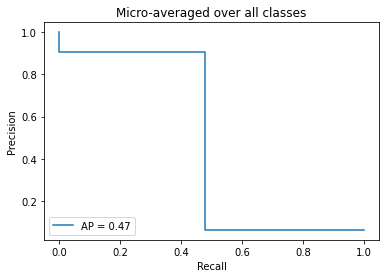

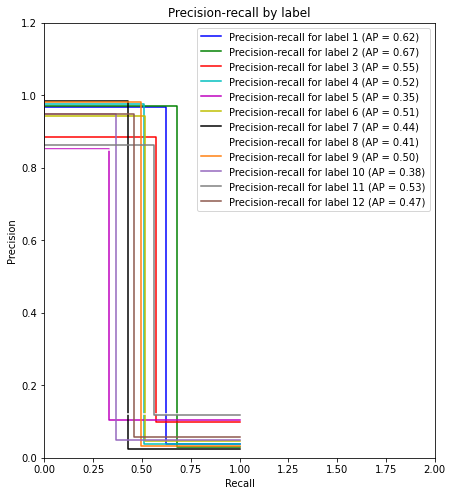

In [7]:
#train set stats
metrics.get_multilabel_stats(regression_model, train_dataset.X, train_dataset.y, 20)

+---------------------+---------+------+------+------+------+------+------+------+------+------+------+------+------+
|                     | Average |  1   |  2   |  3   |  4   |  5   |  6   |  7   |  8   |  9   |  10  |  11  |  12  |
+---------------------+---------+------+------+------+------+------+------+------+------+------+------+------+------+
|  Average Precision  |   0.15  | 0.18 | 0.29 | 0.19 | 0.10 | 0.14 | 0.14 | 0.03 | 0.14 | 0.14 | 0.11 | 0.27 | 0.13 |
|   Top 20 Precision  |   0.35  | 0.40 | 0.35 | 0.50 | 0.25 | 0.35 | 0.30 | 0.10 | 0.15 | 0.35 | 0.30 | 0.75 | 0.40 |
| False negative rate |   0.05  | 0.03 | 0.01 | 0.08 | 0.03 | 0.07 | 0.03 | 0.02 | 0.11 | 0.03 | 0.04 | 0.09 | 0.04 |
+---------------------+---------+------+------+------+------+------+------+------+------+------+------+------+------+


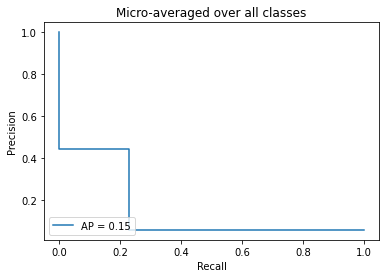

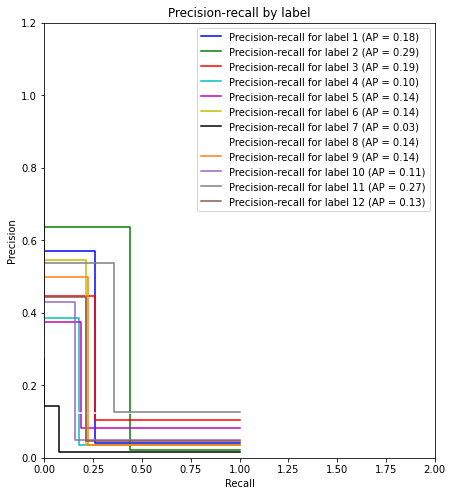

In [9]:
#valid set stats
metrics.get_multilabel_stats(regression_model, valid_dataset.X, valid_dataset.y, 20)

In [10]:
forest_model = ensemble.RandomForestClassifier(min_samples_split=10)
forest_model.fit(train_dataset.X, train_dataset.y)

RandomForestClassifier(min_samples_split=10)

+---------------------+---------+------+------+------+------+------+------+------+------+------+------+------+------+
|                     | Average |  1   |  2   |  3   |  4   |  5   |  6   |  7   |  8   |  9   |  10  |  11  |  12  |
+---------------------+---------+------+------+------+------+------+------+------+------+------+------+------+------+
|  Average Precision  |   0.38  | 0.46 | 0.49 | 0.55 | 0.24 | 0.33 | 0.37 | 0.10 | 0.42 | 0.18 | 0.16 | 0.59 | 0.23 |
|   Top 20 Precision  |   0.93  | 0.80 | 0.85 | 1.00 | 0.95 | 1.00 | 1.00 | 0.60 | 1.00 | 1.00 | 1.00 | 1.00 | 1.00 |
| False negative rate |   0.04  | 0.02 | 0.01 | 0.05 | 0.03 | 0.08 | 0.03 | 0.02 | 0.08 | 0.03 | 0.04 | 0.06 | 0.05 |
+---------------------+---------+------+------+------+------+------+------+------+------+------+------+------+------+


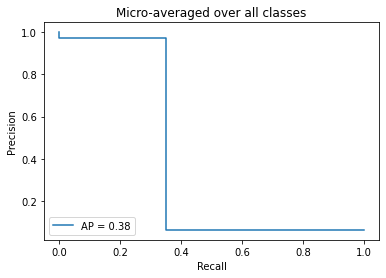

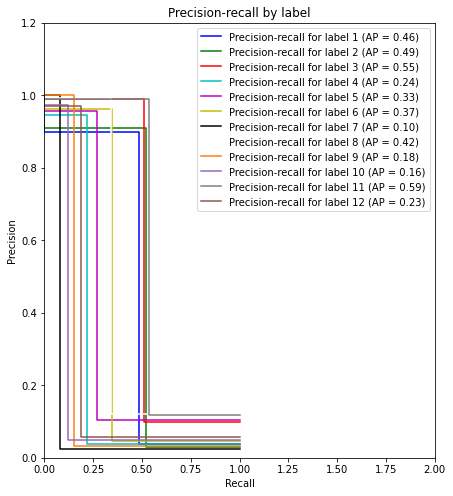

In [11]:
metrics.get_multilabel_stats(forest_model, train_dataset.X, train_dataset.y, 20)

+---------------------+---------+------+------+------+------+------+------+------+------+------+------+------+------+
|                     | Average |  1   |  2   |  3   |  4   |  5   |  6   |  7   |  8   |  9   |  10  |  11  |  12  |
+---------------------+---------+------+------+------+------+------+------+------+------+------+------+------+------+
|  Average Precision  |   0.11  | 0.24 | 0.35 | 0.13 | 0.05 | 0.16 | 0.14 | 0.02 | 0.16 | 0.03 | 0.05 | 0.15 | 0.05 |
|   Top 20 Precision  |   0.23  | 0.40 | 0.35 | 0.30 | 0.05 | 0.35 | 0.25 | 0.05 | 0.35 | 0.10 | 0.10 | 0.30 | 0.10 |
| False negative rate |   0.06  | 0.03 | 0.01 | 0.10 | 0.03 | 0.07 | 0.03 | 0.02 | 0.12 | 0.03 | 0.05 | 0.12 | 0.05 |
+---------------------+---------+------+------+------+------+------+------+------+------+------+------+------+------+


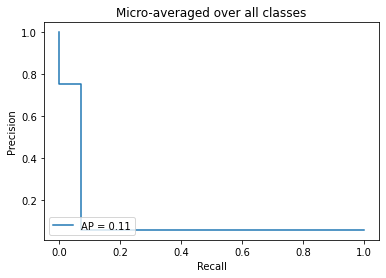

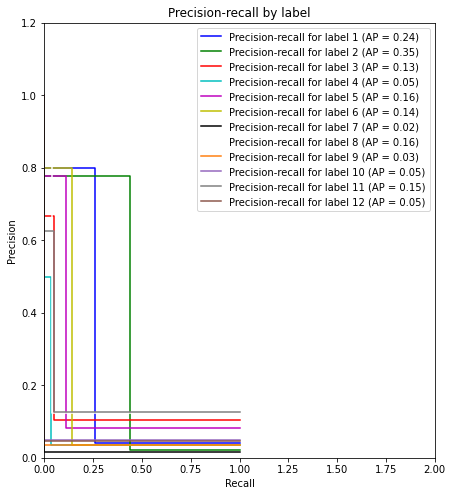

In [12]:
metrics.get_multilabel_stats(forest_model, valid_dataset.X, valid_dataset.y, 20)